In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Institutional_data_full.csv")

data.replace('..', np.nan, inplace=True)

categorical_cols = data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col].astype(str))

# Define hyperparameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1, 0.5, 0.3]
}

In [3]:
rf = RandomForestRegressor(random_state=78)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=30,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=78,
    n_jobs=-1
)

# Prepare data for tuning (use non-missing rows only)
X = data.dropna()
X_features = X.drop(columns=categorical_cols)

# Fit RandomizedSearchCV
random_search.fit(X_features, X_features)
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Use best parameters in RandomForestRegressor for IterativeImputer
rf_imputer = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=42
    ),
    random_state=42
)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 20}


In [5]:
df_imputed_rf = pd.DataFrame(rf_imputer.fit_transform(data), columns=data.columns)

# Decode categorical columns back to original labels
for col in categorical_cols:
    df_imputed_rf[col] = label_encoders[col].inverse_transform(df_imputed_rf[col].astype(int))

# Save the imputed dataset
df_imputed_rf.to_csv("Imputed_Institutional_Data.csv", index=False)

#### Imputer Evaluation

C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


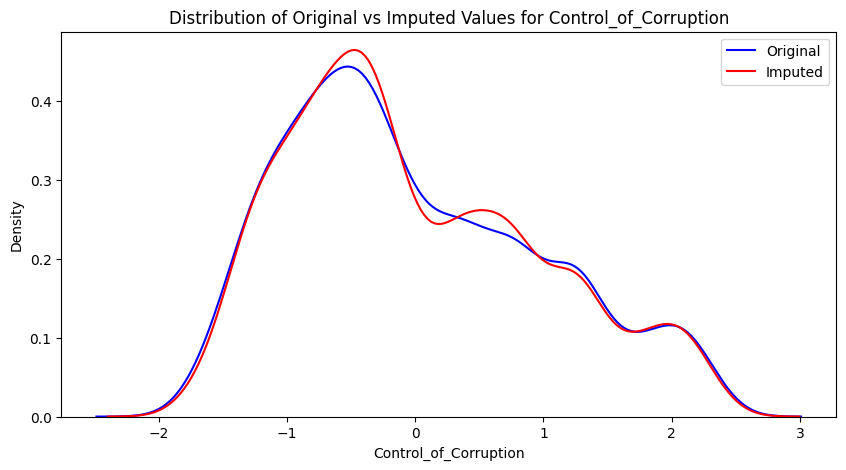

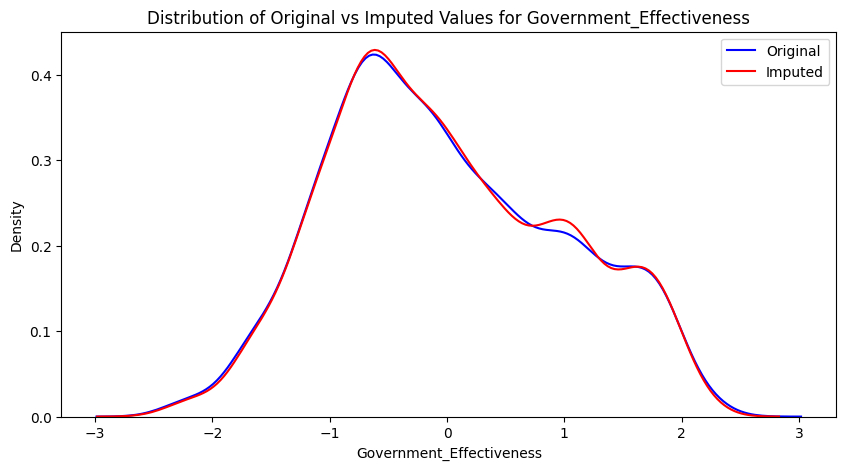

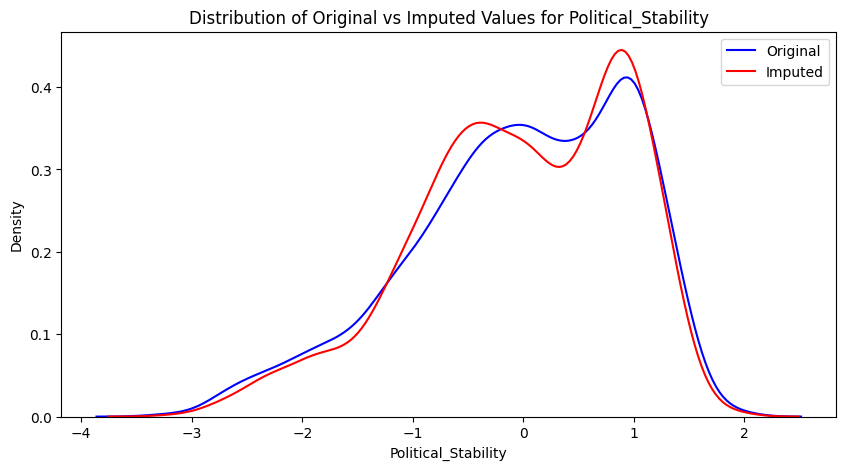

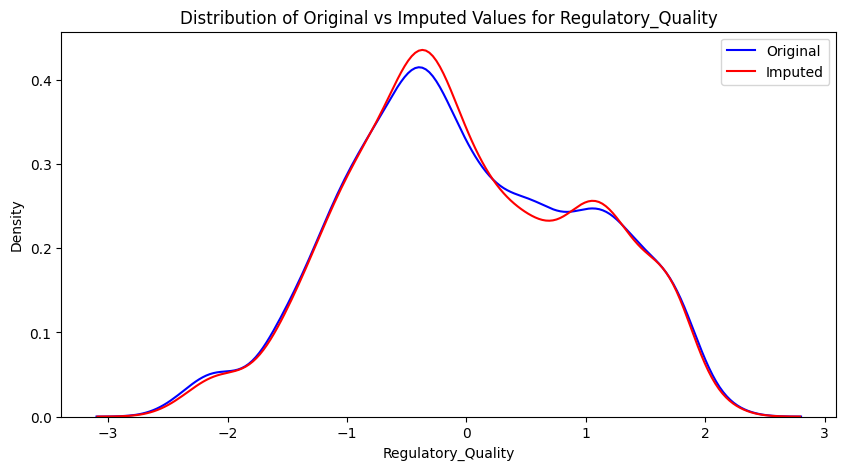

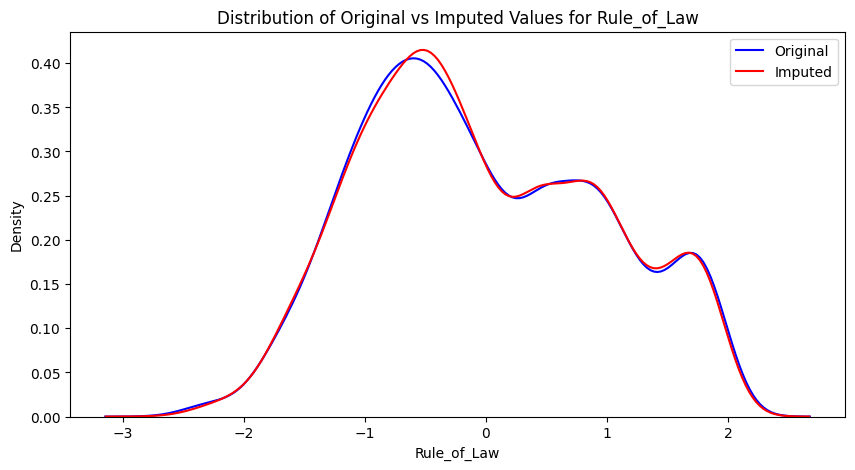

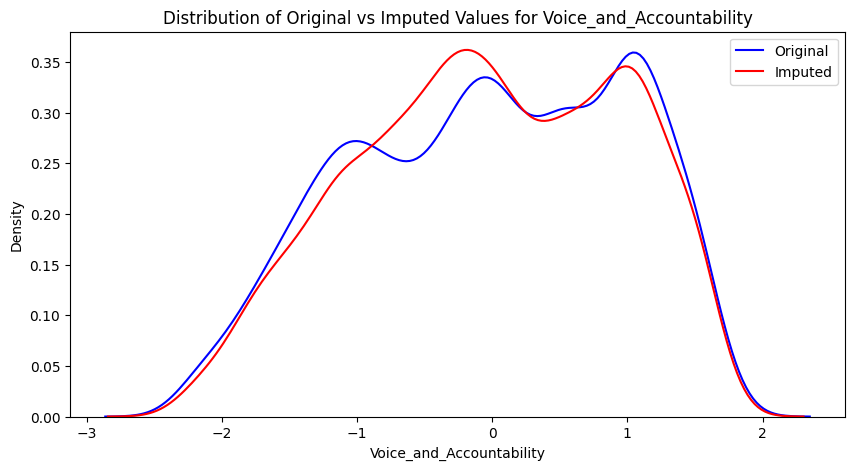

                     target       R^2      RMSE       MAE
0     Control_of_Corruption  0.974522  0.159626  0.065531
1  Government_Effectiveness  0.974742  0.158687  0.065570
2       Political_Stability  0.913370  0.293435  0.120041
3        Regulatory_Quality  0.966206  0.183610  0.073384
4               Rule_of_Law  0.979289  0.144384  0.059456
5  Voice_and_Accountability  0.921141  0.280029  0.111145


In [6]:
synthetic_data = pd.read_csv('synthetic_data_institution.csv')
full_data = pd.read_csv('synthetic_data_institution_full.csv')

rf_imputer = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=29
    ),
    random_state=29
)

synthetic_data_imputed = pd.DataFrame(rf_imputer.fit_transform(synthetic_data), columns=synthetic_data.columns)

# Initialize metrics storage
metrics = {'target': [], 'R^2': [], 'RMSE': [], 'MAE': []}

# Calculate R^2, RMSE, MAE for each column with missing values
missing_columns = synthetic_data.columns[synthetic_data.isnull().any()]

for column in missing_columns:
    y_true = full_data[column]
    y_pred = synthetic_data_imputed[column]

    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Append metrics for this target
    metrics['target'].append(column)
    metrics['R^2'].append(r2)
    metrics['RMSE'].append(rmse)
    metrics['MAE'].append(mae)
    
    # Plot distribution comparison
    plt.figure(figsize=(10, 5))
    sns.kdeplot(y_true, label='Original', color='blue')
    sns.kdeplot(y_pred, label='Imputed', color='red')
    plt.title(f"Distribution of Original vs Imputed Values for {column}")
    plt.xlabel(column)
    plt.legend()
    plt.show()

# Display metrics as a DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

In [4]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load the full dataset
full_data = pd.read_csv('synthetic_data_institution_full.csv')

# Split the full data into 60-40 for training and testing
train_data, test_data = train_test_split(full_data, test_size=0.4, random_state=29)

# Create synthetic missing data in the test set by randomly setting values to NaN
np.random.seed(29)
missing_fraction = 0.70  # 20% of the data will be randomly masked as NaN
for column in test_data.columns:
    mask = np.random.rand(test_data.shape[0]) < missing_fraction
    test_data.loc[mask, column] = np.nan

# Initialize metrics storage
metrics = {'target': [], 'R^2': [], 'RMSE': [], 'MAE': []}

# Perform imputation and evaluation over 30 runs
for run in range(30):
    # Initialize Iterative Imputer with RandomForestRegressor using best parameters
    rf_imputer = IterativeImputer(
        estimator=RandomForestRegressor(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            max_features=best_params['max_features'],
            random_state=29 + run
        ),
        random_state=29 + run
    )

    # Perform imputation on the test data
    test_data_imputed = pd.DataFrame(rf_imputer.fit_transform(test_data), columns=test_data.columns)

    # Calculate metrics for each column with synthetic missing values
    missing_columns = test_data.columns[test_data.isnull().any()]

    for column in missing_columns:
        y_true = full_data.loc[test_data.index, column]  # Use the original full data as ground truth
        y_pred = test_data_imputed[column]

        # Calculate metrics
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)

        # Append metrics for this target
        metrics['target'].append(column)
        metrics['R^2'].append(r2)
        metrics['RMSE'].append(rmse)
        metrics['MAE'].append(mae)

# Display metrics as a DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [Itera

                       target       R^2      RMSE       MAE
0       Control_of_Corruption  0.768785  0.487495  0.293305
1    Government_Effectiveness  0.766692  0.488473  0.290532
2         Political_Stability  0.602298  0.633172  0.390247
3          Regulatory_Quality  0.729292  0.524090  0.313853
4                 Rule_of_Law  0.786535  0.469357  0.281332
..                        ...       ...       ...       ...
175  Government_Effectiveness  0.765723  0.489486  0.293794
176       Political_Stability  0.599047  0.635754  0.394103
177        Regulatory_Quality  0.721646  0.531440  0.320096
178               Rule_of_Law  0.785605  0.470378  0.280488
179  Voice_and_Accountability  0.594355  0.642197  0.399211

[180 rows x 4 columns]


C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
metrics_summary = metrics_df.groupby('target').agg(
    R2_mean=('R^2', 'mean'),
    R2_std=('R^2', 'std'),
    RMSE_mean=('RMSE', 'mean'),
    RMSE_std=('RMSE', 'std'),
    MAE_mean=('MAE', 'mean'),
    MAE_std=('MAE', 'std')
).reset_index()

# Display the summarized metrics
print(metrics_summary)

                     target   R2_mean    R2_std  RMSE_mean  RMSE_std  \
0     Control_of_Corruption  0.769816  0.005493   0.486374  0.005756   
1  Government_Effectiveness  0.768785  0.003794   0.486260  0.003993   
2       Political_Stability  0.603937  0.010688   0.631811  0.008427   
3        Regulatory_Quality  0.731917  0.007618   0.521492  0.007416   
4               Rule_of_Law  0.787469  0.003345   0.468315  0.003674   
5  Voice_and_Accountability  0.640950  0.013479   0.604089  0.011158   

   MAE_mean   MAE_std  
0  0.292626  0.001540  
1  0.291132  0.001339  
2  0.390729  0.005653  
3  0.315485  0.002582  
4  0.280026  0.001443  
5  0.377397  0.006841  
